Q1-CLAHE

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import math
import cv2

In [100]:
def clahe(image, clip_limit=2.0, grid_size=(8, 8)):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    tile_size = (gray.shape[0] // grid_size[0], gray.shape[1] // grid_size[1])
    clahe_image = np.zeros_like(gray)

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):

            tile = gray[i * tile_size[0]: (i + 1) * tile_size[0], j * tile_size[1]: (j + 1) * tile_size[1]]
            tile_eq = cv2.equalizeHist(tile)

            hist, _ = np.histogram(tile_eq.flatten(), bins=256, range=[0, 256])

            cdf = hist.cumsum()
            cdf = np.clip(cdf, 0, tile_size[0] * tile_size[1] * clip_limit / 256)
            cdf = cdf * 255 / (tile_size[0] * tile_size[1])

            if i > 0:
                neighbor = clahe_image[(i - 1) * tile_size[0]: i * tile_size[0], j * tile_size[1]: (j + 1) * tile_size[1]]
                neighbor = cv2.resize(neighbor, (tile_size[1], tile_size[0]))
                tile_eq[:1, :] = (tile_eq[:1, :] + neighbor[:1, :]) // 2

            if j > 0:
                neighbor = clahe_image[i * tile_size[0]: (i + 1) * tile_size[0], (j - 1) * tile_size[1]: j * tile_size[1]]
                neighbor = cv2.resize(neighbor, (tile_size[1], tile_size[0]))
                tile_eq[:, :1] = (tile_eq[:, :1] + neighbor[:, :1]) // 2
                
            clahe_image[i * tile_size[0]: (i + 1) * tile_size[0], j * tile_size[1]: (j + 1) * tile_size[1]] = tile_eq

    return clahe_image


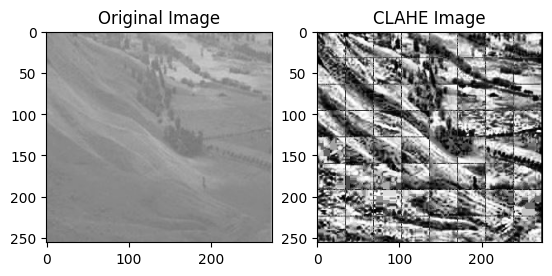

In [101]:
image = cv2.imread('image1.jpg')

clahe_image = clahe(image)
plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(122), plt.imshow(clahe_image, cmap='gray'), plt.title('CLAHE Image')
plt.show()

### In this exercise we aim to compare wiener and inverse filters while image is blurred and noisy.

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import math
import cv2

### In the first step read `sample.jpg` image then use `motion_process()` and `make_blurred()` functions to apply a motion blur on input image.

In [37]:
# Simulated motion blur
def motion_process(image_size, motion_angle=60):
    """
    image_size: a tuple(image_height, image_width)
    """
    PSF = np.zeros(image_size)
    center_position = (image_size[0] - 1) / 2

    slope_tan = math.tan(motion_angle * math.pi / 180)
    slope_cot = 1 / slope_tan
    if slope_tan <= 1:
        for i in range(15):
            offset = round(i * slope_tan) 
            PSF[int(center_position + offset), int(center_position - offset)] = 1
        return PSF / PSF.sum()  
    else:
        for i in range(15):
            offset = round(i * slope_cot)
            PSF[int(center_position - offset), int(center_position + offset)] = 1
        return PSF / PSF.sum()


def make_blurred(input, PSF):
    """
    input: original image
    PSF: point spread function (PSF) describes the response of a focused optical imaging system
         to a point source or point object. i.e. it is output of motion_process() function.
    """
    input_fft = fft.fft2(input)  
    PSF_fft = fft.fft2(PSF) 
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(blurred)
    return blurred

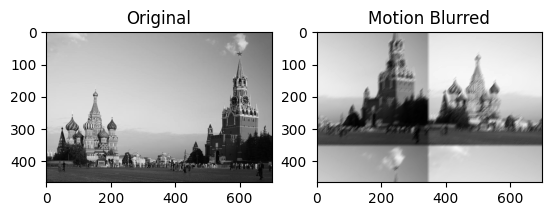

In [44]:
# TODO: read input image. Then show both original and motion blurred image. 

image = cv2.imread('sample.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image_size = gray_image.shape[::-1]
PSF = motion_process(image_size, motion_angle=60)

motion_blurred = make_blurred(gray_image, PSF.T)

plt.subplot(121), plt.imshow(gray_image, cmap='gray'), plt.title('Original')
plt.subplot(122), plt.imshow(motion_blurred, cmap='gray'), plt.title('Motion Blurred')
plt.show()

### In the second step write two functions for wiener and inverse filters. Then use them to restore blurred image. At last show the outputs.

In [45]:
def wiener_filter(blurred, PSF):
    blurred_fft = np.fft.fft2(blurred)
    blurred_fft_shifted = blurred_fft

    PSF_fft = np.fft.fft2(PSF)
    PSF_fft_shifted = PSF_fft

    wiener_spectrum = np.conj(PSF_fft_shifted) / (np.abs(PSF_fft_shifted) ** 2)
    wiener_result_fft_shifted = blurred_fft_shifted * wiener_spectrum.T
    wiener_result_fft = wiener_result_fft_shifted
    wiener_result = np.fft.ifft2(wiener_result_fft)
    wiener_result = np.abs(wiener_result)

    return wiener_result


def inverse_filter(blurred, PSF):
    PSF_fft = np.fft.fft2(PSF)
    PSF_fft_shifted = (PSF_fft)
    PSF_power_spectrum = np.abs(PSF_fft_shifted) ** 2

    inverse_spectrum = np.conj(PSF_fft_shifted) / (PSF_power_spectrum )
    inverse_result_fft_shifted = (np.fft.fft2(blurred)) * inverse_spectrum.T
    inverse_result_fft = (inverse_result_fft_shifted)
    inverse_result = np.fft.ifft2(inverse_result_fft)
    inverse_result = np.abs(inverse_result)

    return inverse_result


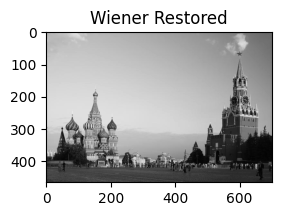

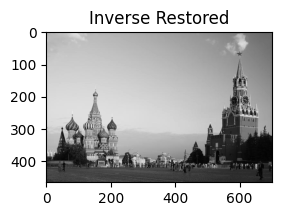

In [46]:
# TODO: show the results of restored degraded images, by filters. 

wiener_restored = wiener_filter(motion_blurred, PSF)
inverse_restored = inverse_filter(motion_blurred, PSF)

plt.subplot(121), plt.imshow(wiener_restored, cmap='gray'), plt.title('Wiener Restored')
plt.show()

plt.subplot(122), plt.imshow(inverse_restored, cmap='gray'), plt.title('Inverse Restored')
plt.show()

### Now use `add_noise()` function to add noise on blurred image. Show blurred and noisy image then use your wiener and inverse filters to restore this image. Show the outputs.

In [77]:
def add_noise(blurred_image):
    blurred_noisy_img = (
        blurred_image
        + 0.001 * blurred_image.std() * np.random.standard_normal(blurred_image.shape)
    )

    return blurred_noisy_img

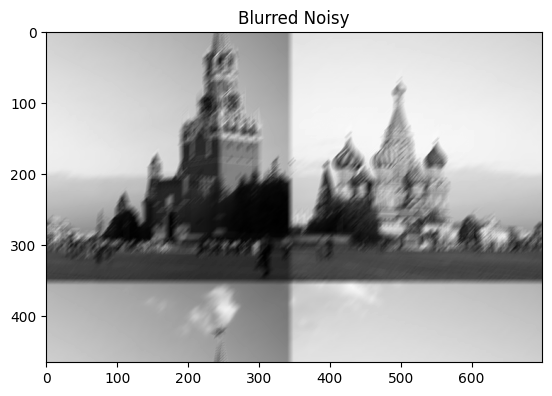

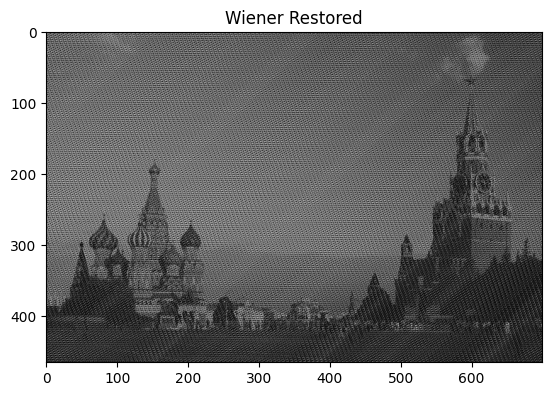

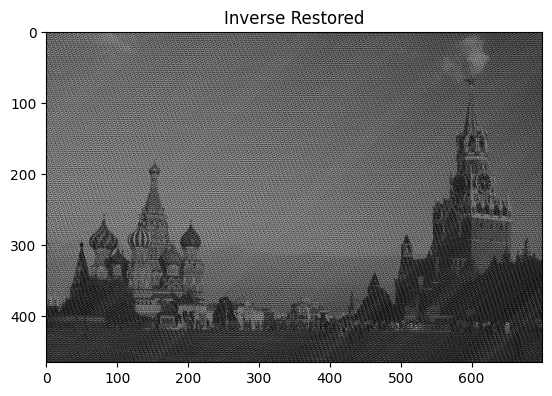

In [78]:
# TODO: apply filters on blurred and noisy image to restore it. Then show the results.

blurred_noisy = add_noise(motion_blurred)

wiener_restored = wiener_filter(blurred_noisy, PSF)
inverse_restored = inverse_filter(blurred_noisy, PSF)


plt.imshow(blurred_noisy, cmap='gray'), plt.title('Blurred Noisy')
plt.show()
plt.imshow(wiener_restored, cmap='gray'), plt.title('Wiener Restored')
plt.show()
plt.imshow(inverse_restored, cmap='gray'), plt.title('Inverse Restored')
plt.show()

### Compare the results of previous step. Which one of the filters worked better after noise addition ?

your answer: 
The inverse filter is generally more sensitive to noise than the Wiener filter.

### In the last step write a function to calculate PSNR between two images. Use this function to compare all previous steps results with original image.

In [79]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    max_pixel = np.max(img1)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


In [80]:
# TODO: compare all results with original image.

psnr_original_wiener = calculate_psnr(gray_image, wiener_restored)
psnr_original_inverse = calculate_psnr(gray_image, inverse_restored)

print('PSNR (Original vs. Wiener Restored):', psnr_original_wiener)
print('PSNR (Original vs. Inverse Restored):', psnr_original_inverse)

PSNR (Original vs. Wiener Restored): 10.00314605145415
PSNR (Original vs. Inverse Restored): 10.00314605145415
